In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/FairPrune"

/content/drive/MyDrive/FairPrune


In [ ]:
%cd "/content/drive/MyDrive/UNSW/FairPrune"


/content/drive/.shortcut-targets-by-id/1mE95vsJWdCLeyosiSlxTV5_-JveJMu0s/FairPrune


In [ ]:
!python Base.py --config Fitz17k_configs.yml

CUDA is available: True 

Starting... 

{'train': 12809, 'val': 3203}
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Fitz17kResNet18(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=

In [3]:
!pip install -q backpack-for-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00


In [5]:
!python FairPrune.py --config Fitz17k_configs.yml

CUDA is available: True 

Starting... 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading model from: /content/drive/MyDrive/FairPrune/Outputs/Resnet18_checkpoint_BASE.pth
+++++++++++++++++++++++++++++ Pruning Iteration 0 +++++++++++++++++++++++++++++
{'train': 8854, 'val': 2209}
{'train': 3955, 'val': 994}
 99% 99/100 [00:53<00:00,  1.84it/s]
average_saliency stats 
{'Mean': 6.638516083512513e-07, 'Std Deviation': 

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc


def cal_metrics(df, type_indices, is_binary=False):
    """
    calculate average accuracy, accuracy per skin type, PQD, DPM, EOM.
    All known skin types
    input val results csv path, type_indices: a list
    output a dic, 'acc_avg': value, 'acc_per_type': array[x,x,x], 'PQD', 'DPM', 'EOM'
    """
    labels_array = np.zeros((6, len(df["label"].unique())))
    correct_array = np.zeros((6, len(df["label"].unique())))
    predictions_array = np.zeros((6, len(df["label"].unique())))
    positive_list = []  # get positive probability for binary classification
    for i in range(df.shape[0]):
        prediction = df.iloc[i]["prediction"]
        label = df.iloc[i]["label"]
        type = df.iloc[i]["fitzpatrick"] - 1
        labels_array[int(type), int(label)] += 1
        predictions_array[int(type), int(prediction)] += 1
        if prediction == label:
            correct_array[int(type), int(label)] += 1

        if is_binary:
            if prediction == 0:
                positive_list.append(1.0 - df.iloc[i]["prediction_probability"])
            else:
                positive_list.append(df.iloc[i]["prediction_probability"])

    correct_array = correct_array[type_indices]
    labels_array = labels_array[type_indices]
    predictions_array = predictions_array[type_indices]

    # avg acc, acc per type
    correct_array_sumc, labels_array_sumc = np.sum(correct_array, axis=1), np.sum(
        labels_array, axis=1
    )  # sum skin conditions
    acc_array = correct_array_sumc / labels_array_sumc
    avg_acc = np.sum(correct_array) / np.sum(labels_array)

    # PQD
    PQD = acc_array.min() / acc_array.max()

    # DPM
    demo_array = predictions_array / np.sum(predictions_array, axis=1, keepdims=True)
    DPM = np.mean(demo_array.min(axis=0) / demo_array.max(axis=0))

    # EOM
    eo_array = correct_array / labels_array
    EOM = np.mean(np.min(eo_array, axis=0) / np.max(eo_array, axis=0))

    print(f"eo_array:{eo_array}")


    # if is binary classification, output AUC
    if is_binary:
        fpr, tpr, threshold = roc_curve(
            df["label"], positive_list, drop_intermediate=True
        )
        AUC = auc(fpr, tpr)
    else:
        AUC = -1

    return {
        "acc_avg": avg_acc,
        "acc_per_type": acc_array,
        "PQD": PQD,
        "DPM": DPM,
        "EOM": EOM,
        "AUC": AUC,
    }


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/FairPrune/Outputs/validation_results_Resnet18_FairPrune_Iter=0.csv")
df

,hasher,label,fitzpatrick,prediction_probability,prediction
0,2902cdd1ebaa4408346ad45372b67de3,2,4,0.992388,2
1,1663f45b286763ea93868bd833c00496,2,3,0.503834,2
2,79afe212abe2babed2e8c270d549da55,2,1,0.994754,2
3,7667396577c8a5828bf9070dd24a67a3,2,6,0.984994,2
4,bcd558c86187bde3ed013eed7b7cfe5f,2,2,0.821930,2
...,...,...,...,...,...
3198,186240638de7f1c3cc66e576e49cef89,2,4,0.999156,2
3199,c52074f991a37d6570d1b82ff645a0d4,2,2,0.999874,1
3200,8d7cda0d2bfbdcd6d5496e8a6e342788,2,3,0.655002,2
3201,e97996fd8e9a1245be0acb3fe3f6a707,2,3,0.958861,2


<Axes: >

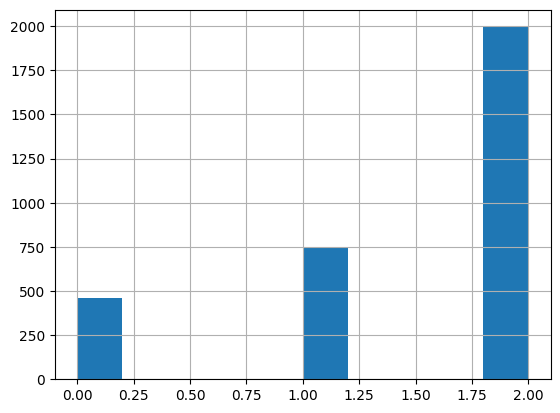

In [ ]:
df['prediction'].hist()

In [ ]:
cal_metrics(df, type_indices=[0, 1, 2, 3, 4, 5], is_binary=False)

eo_array:[[0.         0.01149425 0.98280098]
 [0.         0.00719424 0.97846154]
 [0.         0.00943396 0.97011952]
 [0.         0.01785714 0.96853933]
 [0.         0.03225806 0.92307692]
 [0.         0.16666667 0.7752809 ]]


<ipython-input-8-b4f1f1b608e6>:47: RuntimeWarning: invalid value encountered in divide
  DPM = np.mean(demo_array.min(axis=0) / demo_array.max(axis=0))
<ipython-input-8-b4f1f1b608e6>:51: RuntimeWarning: invalid value encountered in divide
  EOM = np.mean(np.min(eo_array, axis=0) / np.max(eo_array, axis=0))


{'acc_avg': 0.7049640961598501,
 'acc_per_type': array([0.67056856, 0.69014085, 0.70930233, 0.75656743, 0.74110032,
        0.62280702]),
 'PQD': 0.8232009421702404,
 'DPM': nan,
 'EOM': nan,
 'AUC': -1}

In [1]:
import pandas as pd
df = pd.read_csv("/home/ali/Outputs/FairPrune/Pruning_metrics.csv")
df

,acc_avg,acc_per_type,PQD,DPM,EOM,EOpp0,EOpp1,EOdd,NAR,AUC,AUC_per_type,AUC_Gap,acc_avg_binary,acc_per_type_binary,PQD_binary,DPM_binary,EOM_binary,NAR_binary
0,0.834218,[0.82608696 0.81581798 0.83575581 0.84938704 0...,0.930213,0.414492,0.572971,0.151350,0.226136,0.377485,0.073027,-1,-1,-1,0.834218,[0.82480761 0.85513078],0.964540,0.674969,0.856870,0.036100
1,0.817359,[0.80434783 0.79089924 0.8255814 0.83712785 0...,0.915310,0.432114,0.597027,0.156910,0.148523,0.305433,0.088762,-1,-1,-1,0.817359,[0.80534178 0.84406439],0.954124,0.673784,0.887377,0.046953
2,0.813612,[0.79598662 0.79198267 0.81395349 0.84063047 0...,0.920010,0.395917,0.540860,0.150868,0.110564,0.261432,0.083988,-1,-1,-1,0.813612,[0.79990946 0.84406439],0.947688,0.688133,0.924016,0.053717
3,0.813300,[0.79431438 0.78656555 0.82267442 0.83712785 0...,0.920639,0.497763,0.707429,0.138192,0.094205,0.232397,0.082400,-1,-1,-1,0.813300,[0.79990946 0.84305835],0.948819,0.702213,0.923773,0.052526
4,0.808305,[0.79765886 0.78331528 0.81686047 0.82486865 0...,0.930187,0.501884,0.662791,0.148550,0.121611,0.270162,0.071896,-1,-1,-1,0.808305,[0.79764599 0.83199195],0.958718,0.681196,0.860861,0.042152
5,0.801748,[0.78093645 0.78331528 0.80959302 0.8178634 0...,0.927362,0.533560,0.640085,0.168971,0.140293,0.309264,0.075381,-1,-1,-1,0.801748,[0.79085559 0.82595573],0.957504,0.676789,0.865859,0.043419
6,0.803934,[0.78762542 0.78114843 0.81686047 0.81961471 0...,0.927614,0.548318,0.638987,0.159009,0.148646,0.307655,0.074961,-1,-1,-1,0.803934,[0.79402445 0.82595573],0.961340,0.695973,0.868580,0.039422
7,0.803934,[0.78929766 0.78114843 0.81395349 0.81961471 0...,0.927614,0.529400,0.640018,0.164415,0.153181,0.317596,0.074930,-1,-1,-1,0.803934,[0.79357175 0.82696177],0.959623,0.672683,0.857163,0.041209
8,0.802997,[0.78595318 0.77573131 0.81831395 0.82311734 0...,0.929074,0.503702,0.660266,0.158106,0.129414,0.287520,0.072940,-1,-1,-1,0.802997,[0.79176098 0.82796781],0.956270,0.667739,0.856702,0.044707
